In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

In [49]:
data = pd.read_csv('location_aware_gis_leakage_dataset.csv')
data.info()
data.head()
data.isnull().sum()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pressure           5000 non-null   float64
 1   Flow_Rate          5000 non-null   float64
 2   Temperature        5000 non-null   float64
 3   Vibration          5000 non-null   float64
 4   RPM                5000 non-null   float64
 5   Operational_Hours  5000 non-null   int64  
 6   Zone               5000 non-null   object 
 7   Block              5000 non-null   object 
 8   Pipe               5000 non-null   object 
 9   Location_Code      5000 non-null   object 
 10  Latitude           5000 non-null   float64
 11  Longitude          5000 non-null   float64
 12  Leakage_Flag       5000 non-null   int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 507.9+ KB


np.int64(0)

In [50]:
# Separate features and target
y = data['Leakage_Flag']
X = data.drop('Leakage_Flag', axis=1)

In [51]:
# Identify categorical & numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numeric Columns:", num_cols)

Categorical Columns: ['Zone', 'Block', 'Pipe', 'Location_Code']
Numeric Columns: ['Pressure', 'Flow_Rate', 'Temperature', 'Vibration', 'RPM', 'Operational_Hours', 'Latitude', 'Longitude']


In [52]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

C:\Users\asus\AppData\Local\Temp\ipykernel_22468\4137615757.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")


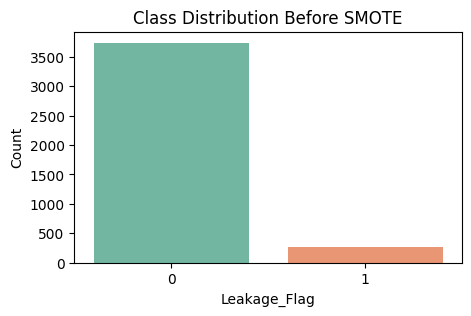

Before SMOTE: {0: 3742, 1: 258}


In [54]:
# Visualize class distribution before SMOTE

plt.figure(figsize=(5,3))
sns.countplot(x=y_train, palette="Set2")
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Leakage_Flag")
plt.ylabel("Count")
plt.show()

print("Before SMOTE:", y_train.value_counts().to_dict())

In [55]:
# Function to evaluate and return trained model
def evaluate_model(clf, model_name):
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   #SMOTE is inside pipeline
        ("classifier", clf)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return pipeline

C:\Users\asus\AppData\Local\Temp\ipykernel_22468\2737772655.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_vis, palette="Set1")


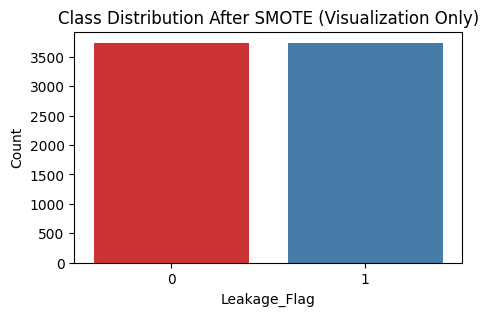

After SMOTE: {0: 3742, 1: 3742}


In [56]:
# Visualize class distribution after SMOTE (for visualization only)
X_train_vis, y_train_vis = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42))
]).fit_resample(X_train, y_train)

plt.figure(figsize=(5,3))
sns.countplot(x=y_train_vis, palette="Set1")
plt.title("Class Distribution After SMOTE (Visualization Only)")
plt.xlabel("Leakage_Flag")
plt.ylabel("Count")
plt.show()

print("After SMOTE:", pd.Series(y_train_vis).value_counts().to_dict())


===== Random Forest =====
Accuracy: 0.989
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       935
           1       1.00      0.83      0.91        65

    accuracy                           0.99      1000
   macro avg       0.99      0.92      0.95      1000
weighted avg       0.99      0.99      0.99      1000



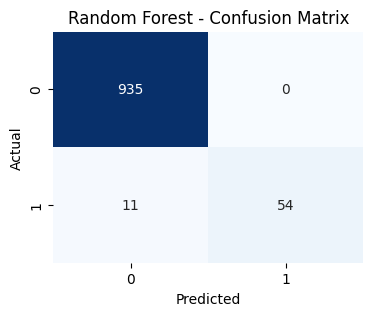


===== Decision Tree =====
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       935
           1       0.04      0.02      0.02        65

    accuracy                           0.91      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.88      0.91      0.89      1000



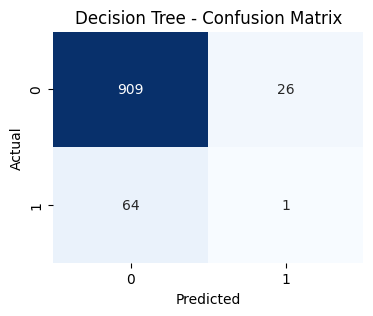


===== Logistic Regression =====
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94       935
           1       0.37      1.00      0.54        65

    accuracy                           0.89      1000
   macro avg       0.69      0.94      0.74      1000
weighted avg       0.96      0.89      0.91      1000



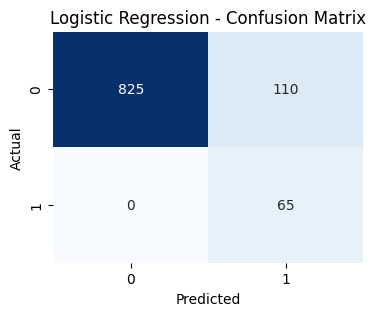


===== Support Vector Machine =====
Accuracy: 0.907
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       935
           1       0.41      0.98      0.58        65

    accuracy                           0.91      1000
   macro avg       0.70      0.94      0.76      1000
weighted avg       0.96      0.91      0.92      1000



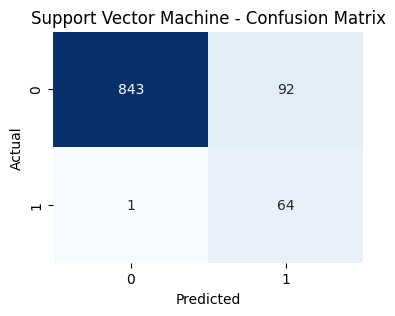

In [57]:
# Train models
rf = evaluate_model(RandomForestClassifier(n_estimators=200, random_state=42), "Random Forest")
dt = evaluate_model(DecisionTreeClassifier(max_depth=3, min_samples_split=50, min_samples_leaf=25, max_features=3, splitter="random", random_state=42), "Decision Tree")
lr = evaluate_model(LogisticRegression(max_iter=100, C=0.01, solver="liblinear", random_state=42), "Logistic Regression")
svm = evaluate_model(SVC(kernel="linear", C=0.01, probability=True, random_state=42), "Support Vector Machine")

In [58]:
for col in ['Zone', 'Block', 'Pipe', 'Location_Code']:
    print(col, "unique values:", X[col].nunique())


Zone unique values: 5
Block unique values: 5
Pipe unique values: 5
Location_Code unique values: 125


In [59]:
print("Model Accuracies:")
for entry in summary:
    print(f"{entry['Model']}: {entry['Accuracy']}")

Model Accuracies:
Random Forest: 0.989
Decision Tree: 0.91
Logistic Regression: 0.89
Support Vector Machine: 0.907


Random Forest AUC: 1.000
Decision Tree AUC: 0.494
Logistic Regression AUC: 0.973
Support Vector Machine AUC: 0.972


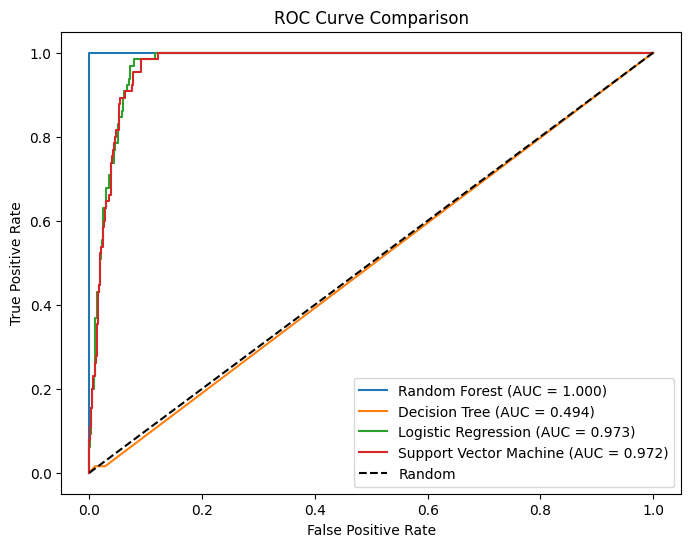

In [60]:
# ROC Curve Comparison and AUC for all models
plt.figure(figsize=(8,6))

for name, model in models.items():
    # Get predicted probabilities for positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    print(f"{name} AUC: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

In [61]:
# Save models (pipelines with preprocessing + SMOTE)
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(dt, "decision_tree_model.pkl")
joblib.dump(lr, "logistic_regression_model.pkl")
joblib.dump(svm, "svm_model.pkl")

print("Models (with preprocessing + SMOTE in pipeline) saved successfully!")

Models (with preprocessing + SMOTE in pipeline) saved successfully!
